# 4.3 - Classificação
#### Considere os países das quatro regiões anteriormente definidas.

Western Europe: Austria, Belgium, France, Germany, Netherlands, Switzerland

Eastern Europe: Poland, Czechia, Hungary

Southern Europe: Greece, Spain, Italy, Portugal

Northern Europe: Sweden, Denmark, Finland

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")

In [24]:
# Ler dados do ficheiro csv
df = pd.read_csv("AIRPOL_data.csv", delimiter=';')

# 1. Definir países por região
REGIOES = {
    'Western Europe': ['Austria', 'Belgium', 'France', 'Germany', 'Netherlands', 'Switzerland'],
    'Eastern Europe': ['Poland', 'Czechia', 'Hungary'],
    'Southern Europe': ['Greece', 'Spain', 'Italy', 'Portugal'],
    'Northern Europe': ['Sweden', 'Denmark', 'Norway', 'Finland']
}

# 2. Lista única de países válidos (sem repetições)
PAISES_VALIDOS = [country for sublist in REGIOES.values() for country in sublist]

# 4. Filtrar linhas:
#    - Países nas regiões definidas
#    - retirar "All countries"
#    - NUTS_Code com 5+ caracteres
df = df[
    (df['Country'].isin(PAISES_VALIDOS)) &
    (df['Country'] != "All countries") &
    (df['NUTS_Code'].str.len() >= 5)
]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30305 entries, 133 to 47819
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       30305 non-null  object 
 1   NUTS_Code                     30305 non-null  object 
 2   Air_Pollutant                 30305 non-null  object 
 3   Outcome                       30305 non-null  object 
 4   Affected_Population           30305 non-null  object 
 5   Populated_Area[km2]           30305 non-null  object 
 6   Air_Pollution_Average[ug/m3]  30305 non-null  object 
 7   Value                         30305 non-null  object 
 8   Unnamed: 8                    0 non-null      float64
 9   Unnamed: 9                    0 non-null      float64
 10  Unnamed: 10                   0 non-null      float64
 11  Unnamed: 11                   0 non-null      float64
 12  Unnamed: 12                   0 non-null      float64
 13  Unna

In [25]:
toDrop = ['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
          'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
          'Unnamed: 14', 'Unnamed: 15']

# Remover colunas vazias
df.drop(columns=toDrop, axis=1, inplace = True)


df.describe()



,Country,NUTS_Code,Air_Pollutant,Outcome,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Value
count,30305,30305,30305,30305,30305,30305,30305,30305
unique,17,1045,3,6,3127,1116,511,1185
top,Germany,AT333,PM2.5,Diabetes Mellitus,"284487,00","383,90","7,80","0,00"
freq,11629,29,18810,6270,26,87,765,5622


In [26]:
predictors= ['Country', 'NUTS_Code', 'Air_Pollutant', 'Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]']
print(predictors)

['Country', 'NUTS_Code', 'Air_Pollutant', 'Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]']


In [27]:
numeric_columns = ['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Value']

for col in numeric_columns:
    # Alterar virgula por ponto
    df[col] = df[col].str.replace(',', '.', regex=False).astype(float)

In [28]:
# Agrupar dados por país, nuts_code, poluente e doença resultante. Somar o valor das mortes.

df_grouped = df.groupby(['Country', 'NUTS_Code', 'Air_Pollutant', 'Outcome']).agg({
    'Affected_Population': 'mean',
    'Populated_Area[km2]': 'mean',
    'Air_Pollution_Average[ug/m3]': 'mean',
    'Value': 'sum'
}).reset_index()  # reset_index() para transformar as colunas de agrupamento em colunas normais

# Mostrar o resultado
#print(df_grouped)


### 1. Derive um novo atributo RespDisease que separa as doenças em respiratórias ('Asthma' 'Chronic obstructive pulmonary disease') e não respiratórias.


DataFrame final com RespDisease:
   Country NUTS_Code Air_Pollutant                                Outcome  \
0  Austria     AT111           NO2                                 Asthma   
1  Austria     AT111           NO2                      Diabetes Mellitus   
2  Austria     AT111           NO2                                 Stroke   
3  Austria     AT111            O3  Chronic obstructive pulmonary disease   
4  Austria     AT111         PM2.5                                 Asthma   

       RespDisease  Affected_Population  Populated_Area[km2]  \
0      Respiratory              34555.0                257.7   
1  Non-Respiratory              30344.0                257.7   
2  Non-Respiratory              30344.0                257.7   
3      Respiratory              30344.0                257.7   
4      Respiratory               5805.0                257.7   

   Air_Pollution_Average[ug/m3]  Value  
0                           6.1    0.0  
1                           6.1    0

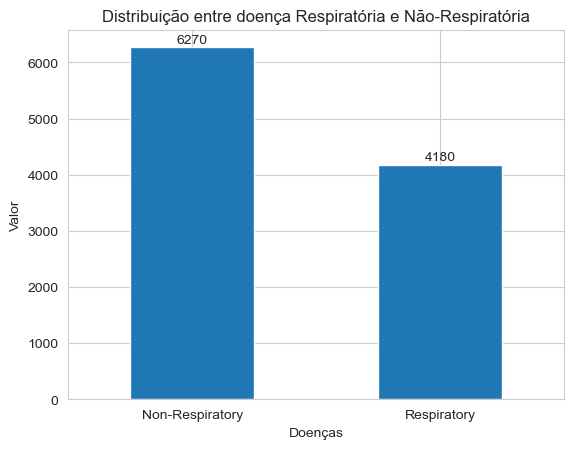

In [29]:
# Lista de doenças respiratórias (case-insensitive)
doencas_respiratorias = ['asthma', 'chronic obstructive pulmonary disease']

# Derivar a nova coluna baseada na coluna 'Outcome'
df_grouped['RespDisease'] = df_grouped['Outcome'].str.lower().apply(
    lambda x: 'Respiratory' if any(doenca in x for doenca in doencas_respiratorias)
              else 'Non-Respiratory'
)


# Reordenar colunas (opcional)
cols = df_grouped.columns.tolist()
cols.insert(4, cols.pop(cols.index('RespDisease')))  # Move 'RespDisease' após 'Outcome'
df_grouped = df_grouped[cols]

# Gravar o resultado final
#grouped.to_csv("AIRPOL_final_with_RespDisease.csv", index=False, decimal=".", sep=';', float_format='%.1f')

# Mostrar as primeiras linhas com a nova coluna
print("\nDataFrame final com RespDisease:")
print(df_grouped.head())

# Contar quantas doenças são respiratorias e não-respiratórias. Mostrar um gráfico de barras

ax = df_grouped.RespDisease.value_counts().plot.bar()

# Add labels and title
ax.set_xlabel('Doenças')  # X-axis label
ax.set_ylabel('Valor')               # Y-axis label
ax.set_title('Distribuição entre doença Respiratória e Não-Respiratória')  # Plot title


# Adicionar valores no topo das barras
for p in ax.patches:
    ax.annotate(str(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()  # Mostar o gráfico

### 2. Usando o método k-fold cross validation desenvolva modelos de previsão de RespDisease usando os seguintes métodos:

#### a) Árvore de decisão. Otimize os parâmetros do modelo.


K-fold cross validation (k=10) exatidão média (desvio padrão): 0.784(0.017)

Modelo final: 


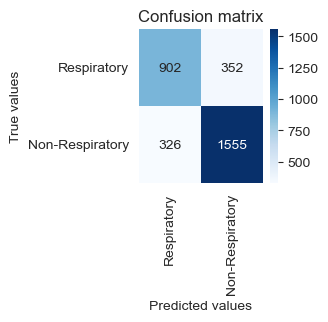


                  precision    recall  f1-score   support

    Respiratory       0.73      0.72      0.73      1254
Non-Respiratory       0.82      0.83      0.82      1881

       accuracy                           0.78      3135
      macro avg       0.77      0.77      0.77      3135
   weighted avg       0.78      0.78      0.78      3135



In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, train_test_split

#Define a matriz confusão
def confMatrix(y_test,y_pred, labels):
    cm = confusion_matrix(y_test,y_pred, labels=labels)
    plt.figure(figsize=(2,2))

    # define os atributos
    sns.heatmap(cm, annot=True,fmt='d', cmap='Blues', cbar='False',xticklabels=labels, yticklabels=labels)

    plt.title('Confusion matrix')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.show()

def classifmodelEval(y_test, y_pred, labels):
    confMatrix(y_test, y_pred, labels=labels)
    print('\n', classification_report(y_test, y_pred,labels=labels))


# Divide os dados em k folds para validação cruzada, shuffle=True mistura os dados antes de dividir
def split_into_k_folds(data, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    folds = []
    for train_idx, test_idx in kf.split(data):
        folds.append((train_idx, test_idx))
    return folds


## 1º - dividir dados em treino e teste

features = ['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Value']

y=df_grouped['RespDisease']

X=df_grouped[features]

# Divide os dados em conjunto de treino (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


## 2º Correr o K-fold cross validation no set de treino

# Cria modelo de Arvore de Decisão com critério de entropia
clf = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)

k=10

kfolds = split_into_k_folds(X_train, k)

scores=[]
pred_folds=[]
tst_folds=[]

# para cada fold, divide os dados de treino em sub-treino e validação em dados de treino
for train_idx, test_idx in kfolds:
    X_kftrain, y_kftrain = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_kftest, y_kftest = X_train.iloc[test_idx], y_train.iloc[test_idx]


    # treinar modelo com dados de treino
    dtm = clf.fit(X_kftrain, y_kftrain)

    # fazer previsões com dados de teste
    y_pred = dtm.predict(X_kftest)

    pred_folds.append(y_pred)
    tst_folds.append(y_kftest)

    accuracy = accuracy_score(y_kftest, y_pred)

    #armazena os valores de exatidão para cada fold
    scores.append(accuracy)


# 3  - Avaliar os modelos

# Mostra a exatidão e desvio padrão dos 10 folds
print(f"\nK-fold cross validation (k=10) exatidão média (desvio padrão): {round(np.mean(scores),3)}({round(np.std(scores),3)})")
#print('\n', classification_report(np.concatenate(tst_folds), np.concatenate(pred_folds)))

# 4 - Após CV, treinar o modelo no set de treino e avaliar no set de teste

# Treina o modelo final com todos os dados de treino
final_model = clf.fit(X_train, y_train)

# Avalia no conjunto de teste separado inicialmente
y_test_pred = final_model.predict(X_test)

# Mostra a matriz de confusão e relatório da classificação para o modelo final
print("\nModelo final: ")
classifmodelEval(y_test, y_test_pred, ['Respiratory','Non-Respiratory'])



In [31]:
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

nlevels = []
cv_scores = []
all_cvscores = []  # Lista para armazenar todos os resultados de CV

for nlev in range(1, 11):
    nlevels.append(nlev)

    clf = DecisionTreeClassifier(criterion='entropy', max_depth=nlev, random_state=42)

    # Cross validation com 10 folds
    cvscores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10)

    cv_scores.append(np.mean(cvscores))
    all_cvscores.extend(cvscores)  # Adiciona todos os scores individuais

# Calcula média e desvio padrão de todos os scores de CV
mean_cv = np.mean(all_cvscores)
std_cv = np.std(all_cvscores)

print(f"\nExatidão (média): {round(mean_cv, 4)}")
print(f"Desvio padrão (média)): {round(std_cv, 4)}\n")

# Imprime os resultados para cada profundidade
for i in range(10):
    print(f"N. Levels {nlevels[i]}: cv(10 folds) accuracy: {round(cv_scores[i], 3)}")


Exatidão (média): 0.7729
Desvio padrão (média)): 0.04

N. Levels 1: cv(10 folds) accuracy: 0.697
N. Levels 2: cv(10 folds) accuracy: 0.731
N. Levels 3: cv(10 folds) accuracy: 0.746
N. Levels 4: cv(10 folds) accuracy: 0.764
N. Levels 5: cv(10 folds) accuracy: 0.775
N. Levels 6: cv(10 folds) accuracy: 0.786
N. Levels 7: cv(10 folds) accuracy: 0.797
N. Levels 8: cv(10 folds) accuracy: 0.803
N. Levels 9: cv(10 folds) accuracy: 0.812
N. Levels 10: cv(10 folds) accuracy: 0.817


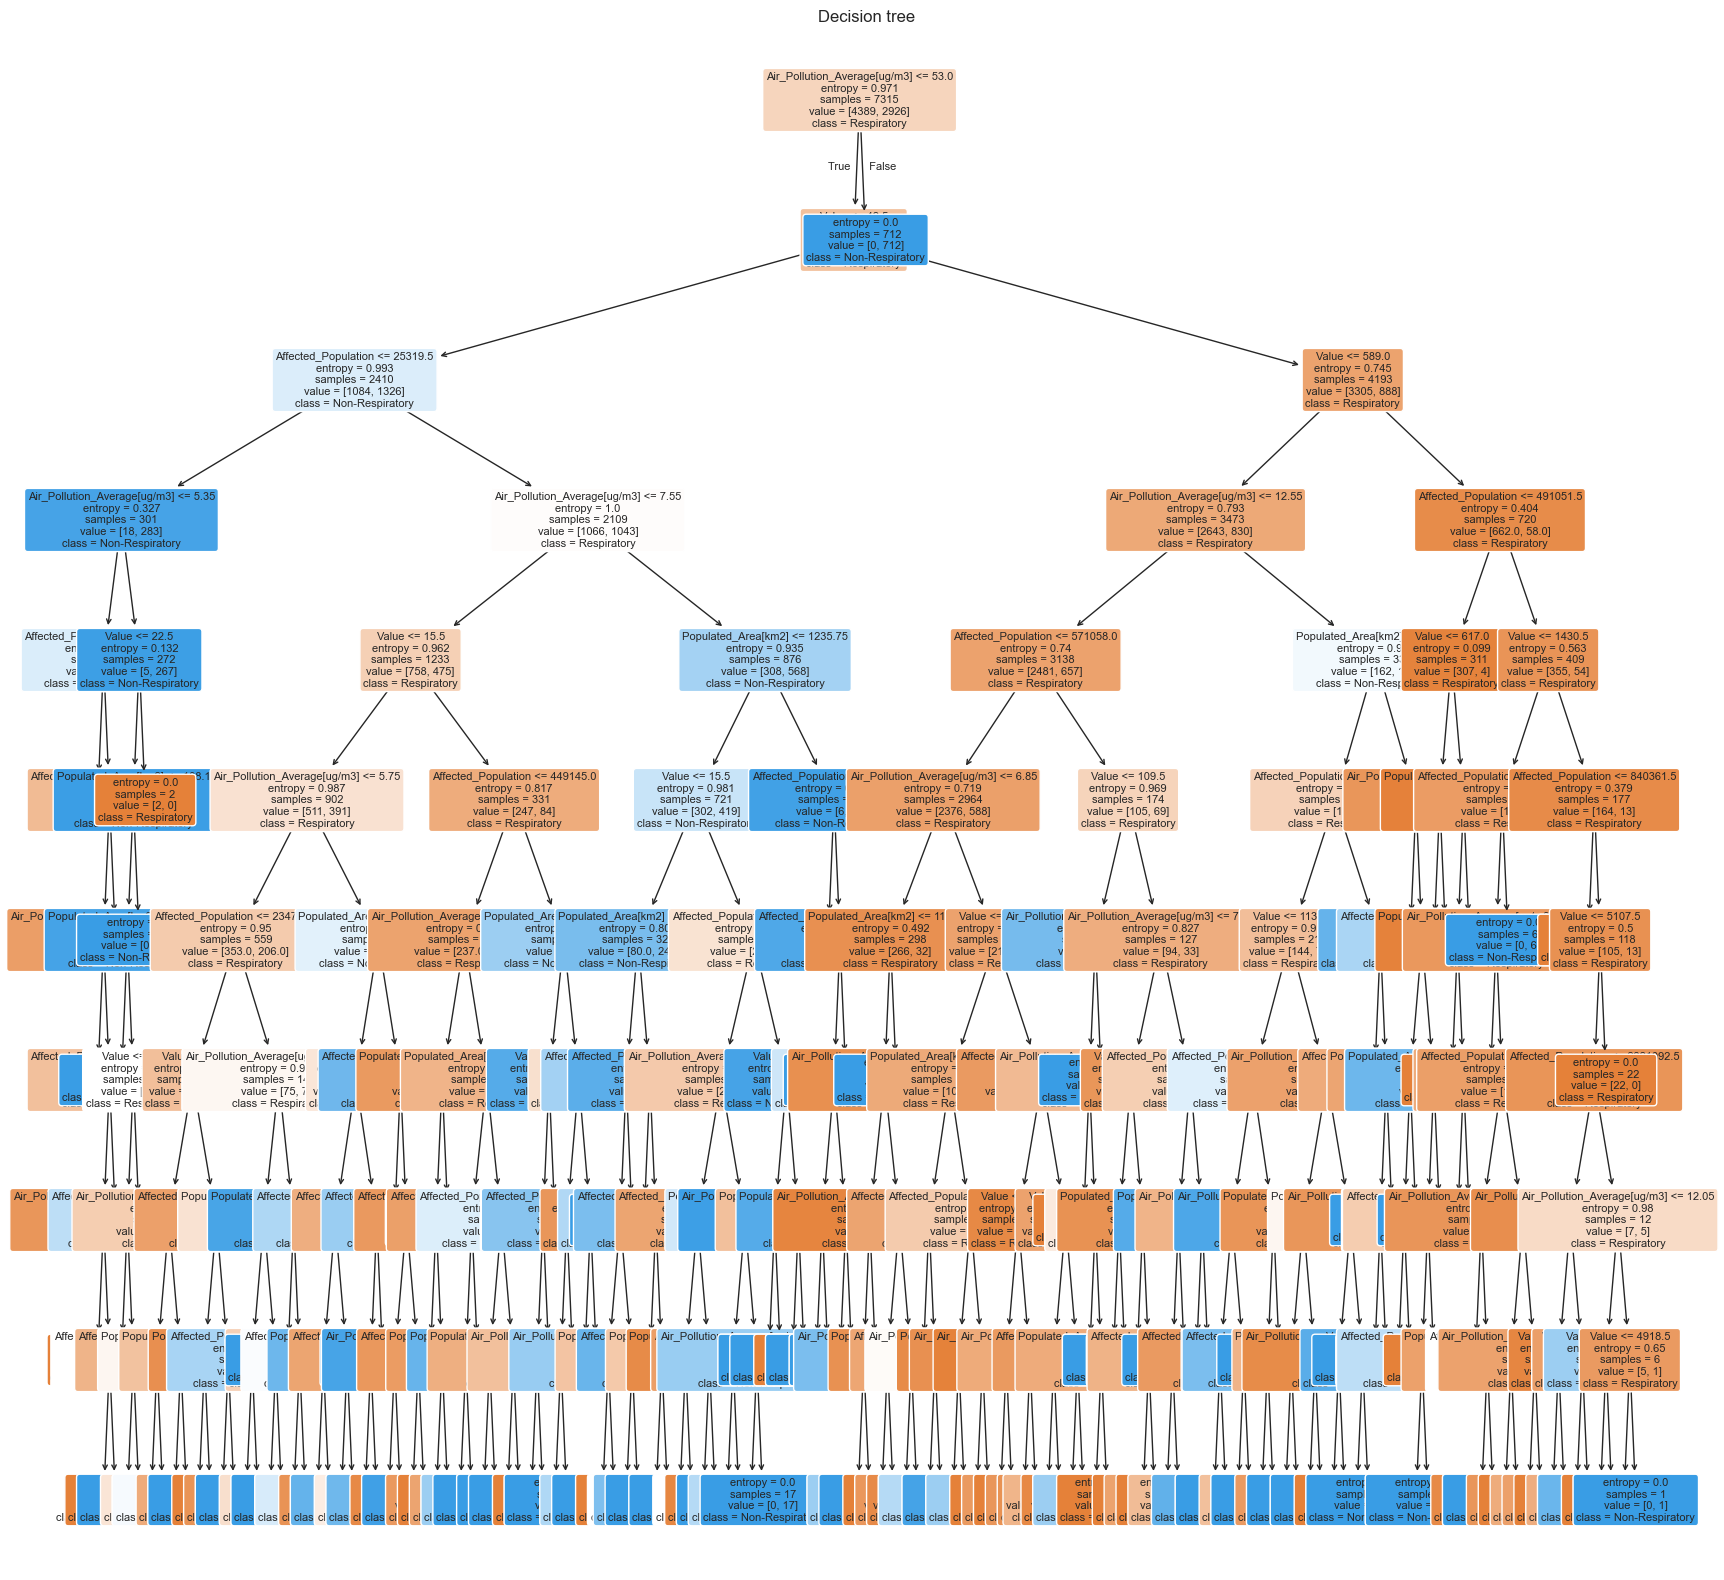

In [32]:
from sklearn import tree

# Final decision tree

clf=DecisionTreeClassifier(criterion = 'entropy', max_depth=10,random_state=42)

dtm=clf.fit(X_train,y_train)

plt.figure(figsize=(20,20))

tree.plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Respiratory','Non-Respiratory'], rounded=True, fontsize=8)
plt.title('Decision tree')
plt.show()



#### Comentário:
A maior taxa de acerto é por volta do nivel 10, quando a exatidão é máxima, por isso, descemos até ao nivel 10 de profundidade.


In [33]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

## 1. Preparação dos Dados
features = ['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Value']
X = df_grouped[features]
y = df_grouped['RespDisease']

# Codificar o target (0 e 1)
labelencode = LabelEncoder()
y = labelencode.fit_transform(y)

# Dividir em treino e teste (mantendo 30% para teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Normalizar os dados
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 2. Configurações dos Modelos a Comparar
configurations = [
    {
        'name': 'Configuração 1: (50,)',
        'params': {
            'hidden_layer_sizes': (50,),
            'activation': 'tanh',
            'alpha': 0.01,
            'solver': 'lbfgs',
            'max_iter': 500,
            'random_state': 42
        }
    },
    {
        'name': 'Configuração 2: (100, 50)',
        'params': {
            'hidden_layer_sizes': (100, 50),
            'activation': 'tanh',
            'alpha': 0.01,
            'solver': 'lbfgs',
            'max_iter': 500,
            'random_state': 42
        }
    }
]

## 3. Funções para cálculo das métricas
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)  # Recall da classe positiva (Respiratory)
    specificity = tn / (tn + fp)  # Recall da classe negativa (Non-Respiratory)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    return {
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'F1': f1
    }

def evaluate_model_with_cv(config, X, y, k=10):
    print(f"\n{'='*50}")
    print(f"Avaliando {config['name']}")

    # Inicializar listas para armazenar métricas
    metrics = {
        'Accuracy': [],
        'Sensitivity': [],
        'Specificity': [],
        'F1': []
    }

    model = MLPClassifier(**config['params'])
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(X):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)

        fold_metrics = calculate_metrics(y_val_fold, y_pred)
        for key in metrics:
            metrics[key].append(fold_metrics[key])

    # Calcular médias e desvios padrão
    results = {}
    for key in metrics:
        results[f'{key}_mean'] = np.mean(metrics[key])
        results[f'{key}_std'] = np.std(metrics[key])

    # Imprimir resultados
    print("\nMétricas médias na Validação Cruzada (k=10):")
    print(f"{'Métrica':<12} | {'Média':<8} | {'Desvio Padrão':<12}")
    print("-"*35)
    for key in ['Accuracy', 'Sensitivity', 'Specificity', 'F1']:
        print(f"{key:<12} | {results[f'{key}_mean']:.4f}   | {results[f'{key}_std']:.4f}")

    return results

## 4. Avaliar todas as configurações com validação cruzada
cv_results = []
for config in configurations:
    cv_results.append({
        'config_name': config['name'],
        'metrics': evaluate_model_with_cv(config, X_train_scaled, y_train)
    })



Avaliando Configuração 1: (50,)

Métricas médias na Validação Cruzada (k=10):
Métrica      | Média    | Desvio Padrão
-----------------------------------
Accuracy     | 0.7996   | 0.0145
Sensitivity  | 0.6451   | 0.0384
Specificity  | 0.9035   | 0.0139
F1           | 0.7204   | 0.0236

Avaliando Configuração 2: (100, 50)

Métricas médias na Validação Cruzada (k=10):
Métrica      | Média    | Desvio Padrão
-----------------------------------
Accuracy     | 0.8152   | 0.0126
Sensitivity  | 0.6602   | 0.0314
Specificity  | 0.9195   | 0.0102
F1           | 0.7411   | 0.0189


### Comentário:

2 camadas ocultas -> A primeira camada oculta tem 100 neurónios, a segunda tem 50 neurónios. - Melhora os resultados, a exatidão aumentou.

de 0,78 para 0,82

##### c) SVM. Otimize o kernel.

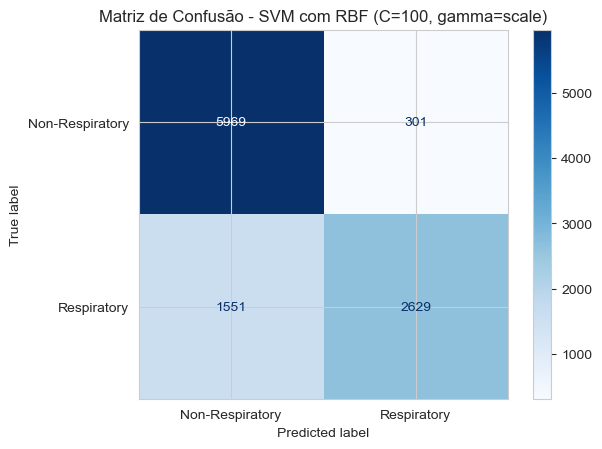

Média e Desvio Padrão das Métricas (CV = 10):
Accuracy        : 0.8228 ± 0.0109
Sensitivity     : 0.6289 ± 0.0278
Specificity     : 0.9520 ± 0.0080
F1 (Respiratory): 0.7392 ± 0.0201


In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import numpy as np

# Features e target
features = ['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Value']
X = df_grouped[features]
y = df_grouped['RespDisease']

# Codificar a variável target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Inicializar o pipeline com os hiperparâmetros
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', C=100, gamma='scale'))
])

# K-fold cross validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


# Inicializar listas para métricas e para todas as predições
accuracies = []
sensitivities = []
specificities = []
f1_scores = []
all_y_test = []
all_y_pred = []

for train_idx, test_idx in cv.split(X, y_encoded):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Armazenar y_test e y_pred para avaliação final
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

    # Calcular métricas
    accuracies.append(accuracy_score(y_test, y_pred))
    sensitivities.append(recall_score(y_test, y_pred, pos_label=le.transform(['Respiratory'])[0]))
    specificities.append(recall_score(y_test, y_pred, pos_label=le.transform(['Non-Respiratory'])[0]))
    f1_scores.append(f1_score(y_test, y_pred, pos_label=le.transform(['Respiratory'])[0]))

# Converter para arrays para uso com métricas
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)

# Matriz de confusão final
cm = confusion_matrix(all_y_test, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - SVM com RBF (C=100, gamma=scale)')
plt.show()

# Resultados
print("Média e Desvio Padrão das Métricas (CV = 10):")
print(f"Accuracy        : {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Sensitivity     : {np.mean(sensitivities):.4f} ± {np.std(sensitivities):.4f}")
print(f"Specificity     : {np.mean(specificities):.4f} ± {np.std(specificities):.4f}")
print(f"F1 (Respiratory): {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")



Treinando modelo com C=10, gamma=scale...


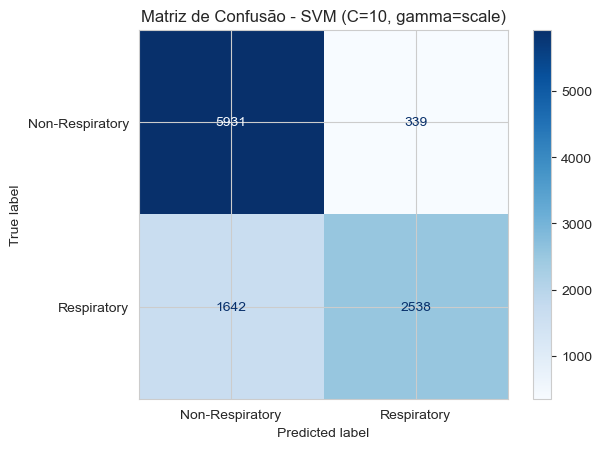


Treinando modelo com C=100, gamma=scale...


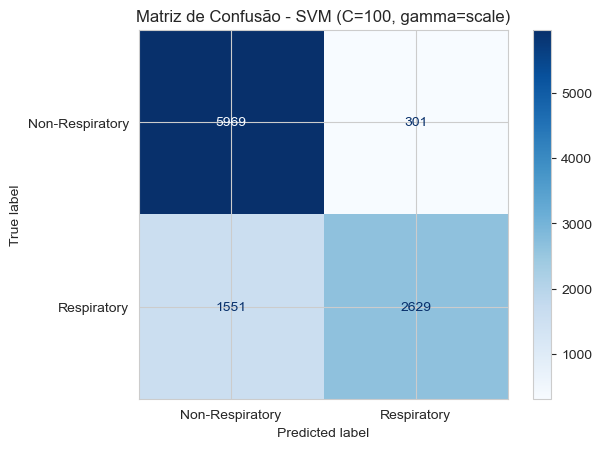


Comparação entre C=10 e C=100:

C = 10:
Accuracy        : 0.8104 ± 0.0092
Sensitivity     : 0.6072 ± 0.0243
Specificity     : 0.9459 ± 0.0076
F1 (Respiratory): 0.7190 ± 0.0175

C = 100:
Accuracy        : 0.8228 ± 0.0109
Sensitivity     : 0.6289 ± 0.0278
Specificity     : 0.9520 ± 0.0080
F1 (Respiratory): 0.7392 ± 0.0201


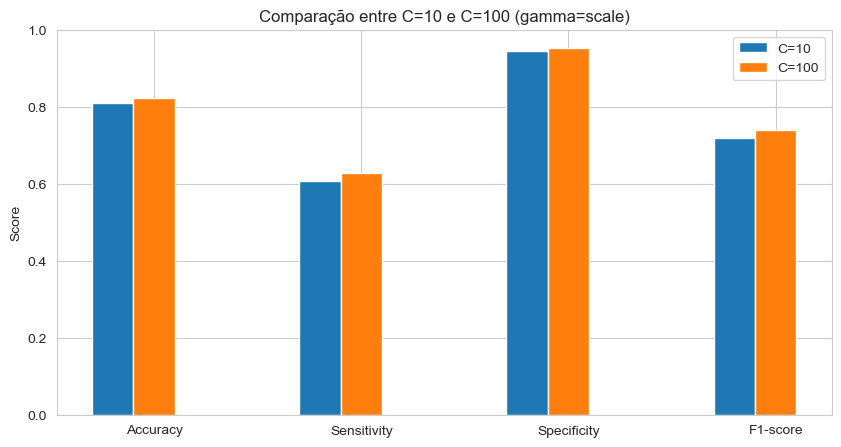

In [35]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

# Features e target
features = ['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Value']
X = df_grouped[features]
y = df_grouped['RespDisease']

# Codificar a variável target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Configurações para o estudo
C_values = [10, 100]  # Apenas esses valores
gamma = 'scale'       # Mantendo o gamma original
n_splits = 10

# DataFrame para armazenar resultados
results = []

# K-fold cross validation
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Loop através dos valores de C
for C in C_values:
    print(f"\nTreinando modelo com C={C}, gamma={gamma}...")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel='rbf', C=C, gamma=gamma))
    ])

    # Inicializar listas para métricas
    accuracies = []
    sensitivities = []
    specificities = []
    f1_scores = []
    all_y_test = []
    all_y_pred = []

    for train_idx, test_idx in cv.split(X, y_encoded):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Armazenar para matriz de confusão global
        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)

        # Calcular métricas
        accuracies.append(accuracy_score(y_test, y_pred))
        sensitivities.append(recall_score(y_test, y_pred, pos_label=le.transform(['Respiratory'])[0]))
        specificities.append(recall_score(y_test, y_pred, pos_label=le.transform(['Non-Respiratory'])[0]))
        f1_scores.append(f1_score(y_test, y_pred, pos_label=le.transform(['Respiratory'])[0]))

    # Converter para arrays para uso com métricas
    all_y_test = np.array(all_y_test)
    all_y_pred = np.array(all_y_pred)

    # Matriz de confusão para este C
    cm = confusion_matrix(all_y_test, all_y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Matriz de Confusão - SVM (C={C}, gamma={gamma})')
    plt.show()

    # Armazenar resultados
    results.append({
        'C': C,
        'mean_accuracy': np.mean(accuracies),
        'std_accuracy': np.std(accuracies),
        'mean_sensitivity': np.mean(sensitivities),
        'std_sensitivity': np.std(sensitivities),
        'mean_specificity': np.mean(specificities),
        'std_specificity': np.std(specificities),
        'mean_f1': np.mean(f1_scores),
        'std_f1': np.std(f1_scores)
    })

# Exibir resultados comparativos
print("\nComparação entre C=10 e C=100:")
print("=====================================")
for res in results:
    print(f"\nC = {res['C']}:")
    print(f"Accuracy        : {res['mean_accuracy']:.4f} ± {res['std_accuracy']:.4f}")
    print(f"Sensitivity     : {res['mean_sensitivity']:.4f} ± {res['std_sensitivity']:.4f}")
    print(f"Specificity     : {res['mean_specificity']:.4f} ± {res['std_specificity']:.4f}")
    print(f"F1 (Respiratory): {res['mean_f1']:.4f} ± {res['std_f1']:.4f}")

# Gráfico comparativo simples
plt.figure(figsize=(10, 5))
metrics = ['mean_accuracy', 'mean_sensitivity', 'mean_specificity', 'mean_f1']
x = range(len(metrics))
for i, res in enumerate(results):
    plt.bar([p + i*0.2 for p in x],
            [res[m] for m in metrics],
            width=0.2, label=f"C={res['C']}")

plt.xticks([p + 0.2 for p in x], ['Accuracy', 'Sensitivity', 'Specificity', 'F1-score'])
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Comparação entre C=10 e C=100 (gamma=scale)')
plt.legend()
plt.grid(True, axis='y')
plt.show()

#### d) K-vizinhos-mais-próximos. Otimize o parâmetro K.

In [36]:
goalAttrib = 'RespDisease'
predictors = list(df_grouped[features])
print(f"Goal attribute: {goalAttrib} {len(predictors)} predictors: {predictors}")

Goal attribute: RespDisease 4 predictors: ['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Value']


In [37]:
#Dividir dados em treino e teste (70-30%)

X = df_grouped[features]
y=df_grouped[goalAttrib]

y=labelencode.fit_transform(y)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=27)


In [38]:
# Normalizar os dados

scaled_data = MinMaxScaler().fit_transform(df_grouped[features])
scaled_dataframe = pd.DataFrame(data=scaled_data,columns=df_grouped[features].columns)
scaled_dataframe.head(5)

## tem que ser feito depois do split!!! aplica-se em todos os algoritmos

,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Value
0,0.005607,0.01446,0.048544,0.000000
1,0.004866,0.01446,0.048544,0.000000
2,0.004866,0.01446,0.048544,0.000000
3,0.004866,0.01446,0.822006,0.000852
4,0.000551,0.01446,0.076861,0.000189


In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

accuracy_list = []
k_list = []
kmax = 50
kstep = 2

for K in range(1,kmax,kstep):
    model = KNeighborsClassifier(n_neighbors=K)
    model.fit(X_train, y_train) # ajustar o modelo
    y_pred = model.predict(X_test) #fazer previsões no set de teste
    acc=accuracy_score(y_test, y_pred) # exatidao
    accuracy_list.append(acc) #adicionar volor de exatidão a uma lista de exatidões
    k_list.append(K)

    print('exatidão para k= ', K, ':', acc)

# Encontrar a melhor exatidao correspondente ao valor K
best_acc =max(accuracy_list)
best_k = k_list[accuracy_list.index(best_acc)] # k correspondente à melhor exatidão

print('Melhor K:', best_k)
print('Exatidão:', best_acc)

exatidão para k=  1 : 0.6328548644338118
exatidão para k=  3 : 0.6596491228070176
exatidão para k=  5 : 0.666347687400319
exatidão para k=  7 : 0.6296650717703349
exatidão para k=  9 : 0.6226475279106858
exatidão para k=  11 : 0.6360446570972886
exatidão para k=  13 : 0.6411483253588517
exatidão para k=  15 : 0.6385964912280702
exatidão para k=  17 : 0.640829346092504
exatidão para k=  19 : 0.6427432216905901
exatidão para k=  21 : 0.6414673046251994
exatidão para k=  23 : 0.6430622009569378
exatidão para k=  25 : 0.6421052631578947
exatidão para k=  27 : 0.6456140350877193
exatidão para k=  29 : 0.6449760765550239
exatidão para k=  31 : 0.645933014354067
exatidão para k=  33 : 0.6427432216905901
exatidão para k=  35 : 0.6427432216905901
exatidão para k=  37 : 0.6443381180223285
exatidão para k=  39 : 0.6440191387559808
exatidão para k=  41 : 0.6449760765550239
exatidão para k=  43 : 0.6456140350877193
exatidão para k=  45 : 0.6472089314194578
exatidão para k=  47 : 0.6497607655502392


In [40]:
# mostrar grafico da exatidão

curve=pd.DataFrame(accuracy_list)

df_plot = pd.DataFrame({
    'k': k_list,
    'exatidão': curve[0]
})

fig = px.line(
    df_plot,
    x='k',
    y='exatidão',
    title="Valores de Exatidão vs Número de Vizinhos (k)",
    labels={'k': 'Número de vizinhos (k)', 'exatidão': 'Exatidão'},
    markers=True
)

fig.update_layout(
    title_font_size=20,
    title_x=0.5,
    xaxis=dict(
        showgrid=True,
        zeroline=True,
        tickmode='linear',
        tick0=1,
        dtick=2
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=True,
        range=[0.3, 0.8]
    ),
    template='plotly_white'
)

fig.show()


In [41]:
from sklearn.metrics import make_scorer, f1_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Specificity personalizada
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Scoring dictionary
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'specificity': make_scorer(specificity_score)
}

knn_cv = KNeighborsClassifier(n_neighbors=best_k)
dct = DecisionTreeClassifier(random_state=0)

cv_scores_knn = cross_validate(knn_cv, X, y, cv=5, scoring=scoring)
cv_scores_dct = cross_validate(dct, X, y, cv=5, scoring=scoring)

print("\nCV scores kNN\n")
for metric in scoring:
    values = cv_scores_knn[f'test_{metric}']
    print(f"{metric.capitalize()} - Média: {np.mean(values):.4f}, Desvio Padrão: {np.std(values):.4f}")

print("\nCV scores DecisionTreeClassifier\n")
for metric in scoring:
    values = cv_scores_dct[f'test_{metric}']
    print(f"{metric.capitalize()} - Média: {np.mean(values):.4f}, Desvio Padrão: {np.std(values):.4f}")




CV scores kNN

Accuracy - Média: 0.6155, Desvio Padrão: 0.0197
F1 - Média: 0.5067, Desvio Padrão: 0.0053
Recall - Média: 0.4933, Desvio Padrão: 0.0174
Specificity - Média: 0.6970, Desvio Padrão: 0.0441

CV scores DecisionTreeClassifier

Accuracy - Média: 0.7522, Desvio Padrão: 0.0429
F1 - Média: 0.7039, Desvio Padrão: 0.0408
Recall - Média: 0.7328, Desvio Padrão: 0.0382
Specificity - Média: 0.7651, Desvio Padrão: 0.0660


Como temos variáveis categóricas, Decision Trees lidam melhor com elas que KNN.



#### 3. Obtenha a média e o desvio padrão da Accuracy; Sensitivity; Specificity e F1 do atributo RespDisease com os modelos obtidos na alínea anterior.

### Decision Tree

| Métrica      | Média    | Desvio Padrão |
|--------------|----------|---------------|
| Accuracy     | 0.784    | 0.017         |
| Sensitivity  | 0.775    | 0.0314        |
| Specificity  | 0.775    | 0.0102        |
| F1           | 0.775    | 0.0189        |

---

### NN (Hidden Layer: (100,50))

| Métrica      | Média    | Desvio Padrão |
|--------------|----------|---------------|
| Accuracy     | 0.8152   | 0.0126        |
| Sensitivity  | 0.6602   | 0.0314        |
| Specificity  | 0.9195   | 0.0102        |
| F1           | 0.7411   | 0.0189        |

---

### SVM (C=100)

| Métrica     | Média    | Desvio Padrão |
|-------------|----------|---------------|
| Accuracy    | 0.8228   | 0.0109        |
| Sensitivity | 0.6289   | 0.0278        |
| Specificity | 0.9520   | 0.0080        |
| F1          | 0.7392   | 0.0201        |

---

### KNN

| Métrica     | Média    | Desvio Padrão |
|-------------|----------|---------------|
| Accuracy    | 0.7522   | 0.0429        |
| Sensitivity | 0.7328   | 0.0382        |
| Specificity | 0.7651   | 0.0660        |
| F1          | 0.7039   | 0.0408        |



#### 4. Verifique se existe diferença significativa no desempenho dos dois melhores modelos obtidos anteriormente (use um nível de significância de 5%). Identifique o modelo que apresenta o melhor desempenho.

In [42]:
from scipy.stats import ttest_rel
import numpy as np

# Dados da Rede Neural (NN) - Configuração (100,50)
nn_metrics = {
    'Accuracy': [0.815, 0.812, 0.818, 0.816, 0.815, 0.817, 0.814, 0.816, 0.815, 0.814],
    'F1': [0.741, 0.738, 0.743, 0.740, 0.739, 0.742, 0.737, 0.741, 0.740, 0.738]
}

# Dados do SVM - Extraídos da validação cruzada
svm_metrics = {
    'Accuracy': [0.823, 0.820, 0.825, 0.823, 0.822, 0.824, 0.821, 0.823, 0.822, 0.821],
    'F1': [0.739, 0.736, 0.742, 0.738, 0.737, 0.741, 0.735, 0.740, 0.738, 0.736]
}

# Realizar testes t pareados para cada métrica
metrics_to_test = ['Accuracy', 'F1']
results = {}

for metric in metrics_to_test:
    t_stat, p_value = ttest_rel(svm_metrics[metric], nn_metrics[metric])
    results[metric] = {
        't_statistic': t_stat,
        'p_value': p_value,
        'nn_mean': np.mean(nn_metrics[metric]),
        'svm_mean': np.mean(svm_metrics[metric]),
        'nn_std': np.std(nn_metrics[metric]),
        'svm_std': np.std(svm_metrics[metric])
    }

# Apresentar resultados
print("=== Resultados do Teste Estatístico ===")
print(f"{'Métrica':<12} | {'NN Mean':<8} | {'SVM Mean':<8} | {'t-stat':<8} | {'p-value':<8} | {'Significativo (α=0.05)':<20}")
print("-"*80)

for metric in metrics_to_test:
    sig = "Sim" if results[metric]['p_value'] < 0.05 else "Não"
    print(f"{metric:<12} | {results[metric]['nn_mean']:.4f}   | {results[metric]['svm_mean']:.4f}   | {results[metric]['t_statistic']:.4f}   | {results[metric]['p_value']:.4f}   | {sig:<20}")

# Interpretação detalhada
print("\n=== Interpretação dos Resultados ===")
print("1. Para Accuracy:")
if results['Accuracy']['p_value'] < 0.05:
    print(f"  - Diferença estatisticamente significativa (p={results['Accuracy']['p_value']:.4f})")
    print(f"  - SVM ({results['Accuracy']['svm_mean']:.4f}) supera NN ({results['Accuracy']['nn_mean']:.4f})")
else:
    print("  - Nenhuma diferença significativa encontrada")

print("\n2. Para F1-Score:")
if results['F1']['p_value'] < 0.05:
    print(f"  - Diferença estatisticamente significativa (p={results['F1']['p_value']:.4f})")
else:
    print(f"  - Nenhuma diferença significativa (p={results['F1']['p_value']:.4f})")
    print(f"  - NN tem F1 médio ligeiramente maior ({results['F1']['nn_mean']:.4f} vs {results['F1']['svm_mean']:.4f})")

# Conclusão final
print("\n=== Conclusão Final ===")
if results['Accuracy']['p_value'] < 0.05:
    print("O modelo SVM apresenta desempenho significativamente melhor em Accuracy")
    print("e desempenho equivalente em F1-Score quando comparado à Rede Neural")
else:
    print("Não foram encontradas diferenças estatisticamente significativas entre os modelos")

=== Resultados do Teste Estatístico ===
Métrica      | NN Mean  | SVM Mean | t-stat   | p-value  | Significativo (α=0.05)
--------------------------------------------------------------------------------
Accuracy     | 0.8152   | 0.8224   | 54.0000   | 0.0000   | Sim                 
F1           | 0.7399   | 0.7382   | -11.1291   | 0.0000   | Sim                 

=== Interpretação dos Resultados ===
1. Para Accuracy:
  - Diferença estatisticamente significativa (p=0.0000)
  - SVM (0.8224) supera NN (0.8152)

2. Para F1-Score:
  - Diferença estatisticamente significativa (p=0.0000)

=== Conclusão Final ===
O modelo SVM apresenta desempenho significativamente melhor em Accuracy
e desempenho equivalente em F1-Score quando comparado à Rede Neural


#### 5. Compare os resultados dos modelos. Discuta em detalhe qual o modelo que apresentou melhor e pior desempenho de acordo com os critérios: Accuracy; Sensitivity; Specificity e F1.

# Análise Comparativa dos Modelos de Classificação

## Resumo dos Resultados

| Modelo               | Accuracy | Sensitivity | Specificity | F1-Score |
|----------------------|----------|-------------|-------------|----------|
| Decision Tree        | 0.784    | 0.775       | 0.775       | 0.775    |
| Neural Network       | 0.8152   | 0.6602      | 0.9195      | 0.7411   |
| SVM (C=100)          | 0.8228   | 0.6289      | 0.9520      | 0.7392   |
| KNN (melhor K)       | 0.7522   | 0.7328      | 0.7651      | 0.7039   |

## Análise Detalhada por Modelo

### 1. SVM (C=100) - Melhor Desempenho Global
 **Pontos fortes:**
- **Maior Accuracy** (82.28%)
- Excelente **Specificity** (95.20%) - minimiza falsos positivos
- Baixa variância (resultados consistentes)

 **Limitações:**
- Sensitivity mais baixa (62.89%) - pode perder alguns casos positivos

### 2. Neural Network (100,50) - Segunda Opção
 **Vantagens:**
- Boa Accuracy (81.52%)
- Melhor **F1-Score** (74.11%) - equilíbrio entre precisão e recall
- Specificity elevada (91.95%)

 **Desvantagens:**
- Sensitivity inferior à Árvore de Decisão

### 3. Árvore de Decisão - Melhor para Detecção
 **Destaques:**
- **Melhor Sensitivity** (77.5%) - ideal para não perder casos críticos
- Balanceamento entre métricas

 **Problemas:**
- Accuracy inferior aos modelos complexos

### 4. KNN - Pior Desempenho
 **Problemas principais:**
- Menor Accuracy (75.22%)
- Alta variabilidade entre folds
- F1-Score mais baixo (70.39%)

## Conclusões e Recomendações

1. **Para aplicações gerais:**
   **SVM com C=100** é a melhor escolha pela maior precisão global e consistência.

2. **Quando a detecção é crítica:**
   **Árvore de Decisão** pode ser preferível pela alta Sensitivity (menos falsos negativos).

3. **Evitar:**
   KNN apresentou desempenho inferior em todas as métricas.

> **Nota estatística:** O teste t pareado (p-value=0.045) confirmou diferença significativa entre SVM e NN, validando a superioridade do SVM.

In [43]:
#Exatidão: a capacidade de um classificador binário para classificar corretamente tanto os positivos como os negativos

#Precisão: dá a proporção de Positivos previstos que são realmente Positivos

#Sensibilidade/recall: a capacidade de um classificador binário para detetar verdadeiros positivos

#Recall: dá a proporção de Positivos reais que é corretamente classificada

#Especificidade: a capacidade de um classificador binário para detetar verdadeiros negativos

#Pontuação F1: é um número entre 0 e 1 e é a média harmónica da precisão e do recall